In [2]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy as sp
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

In [3]:
#LOADING DATA
stops = pd.read_csv('data/opp-search-marijuana_state.csv')

In [4]:
#PRE-PROCESSING
##Creating dataframe for each state of interest: Colorado (CO) and Washington (WA)
CO = stops[stops['state'].str.contains('CO')]
WA = stops[stops['state'].str.contains('WA')]

##Converting search rates to percents
CO.search_rate = (CO.search_rate).multiply(100)
WA.search_rate = (WA.search_rate).multiply(100)

In [5]:
##checking shapes
print("Shape of WA dataframe: ", WA.shape)
print("Shape of CO dataframe: ", CO.shape)

Shape of WA dataframe:  (57, 5)
Shape of CO dataframe:  (57, 5)


In [6]:
##Creating dataframes for each ethnic origin, for each state
CO_hisp   = CO[CO['driver_race'].str.contains('hispanic')]
CO_black  = CO[CO['driver_race'].str.contains('black')]
CO_white  = CO[CO['driver_race'].str.contains('white')]
WA_hisp   = WA[WA['driver_race'].str.contains('hispanic')]
WA_black  = WA[WA['driver_race'].str.contains('black')]
WA_white  = WA[WA['driver_race'].str.contains('white')]

In [7]:
##Sorting date values by chronological order
###Colorado:
pd.to_datetime(CO_hisp.quarter)
CO_hisp_sorted  = CO_hisp.sort_values(by  = "quarter")
pd.to_datetime(CO_black.quarter)
CO_black_sorted = CO_black.sort_values(by = "quarter")
pd.to_datetime(CO_white.quarter)
CO_white_sorted = CO_white.sort_values(by = "quarter")

###Washington:
pd.to_datetime(WA_hisp.quarter)
WA_hisp_sorted  = WA_hisp.sort_values(by  = "quarter")
pd.to_datetime(WA_black.quarter)
WA_black_sorted = WA_black.sort_values(by = "quarter")
pd.to_datetime(WA_white.quarter)
WA_white_sorted = WA_white.sort_values(by = "quarter")

In [8]:
#COMPUTATION OF THE FITTED LINEAR TRENDS
##Defining a function for the linear regression and plotting of the original curve, the linear regression and confidence interval (CI)
def interpolate(sorted_frame, pre_legalization, axis, color_plot):
    """input: dataframe with the values corresponding to the ethnic origin and the state, and a boolean indicating the time pre or post legalization, 
        the axis for plotting and the specific color of the curves"""

    ###Creation of the dataframe according to the time pre or post legalization
    frame = sorted_frame[sorted_frame['pre_legalization'] == pre_legalization]
    ###Creation of the axis
    x_in = frame.quarter
    x_in = pd.to_datetime(x_in)
    y_in = frame.search_rate
    a = np.array(x_in, dtype = float)
    b = np.array(y_in, dtype = float)

    ###linear regresion
    p = np.polyfit(a, b, 1)
    y_model = np.polyval(p,a)
    x1 = np.linspace(np.min(a), np.max(a), 100)
    y1 = np.polyval(p,x1)
    
    ###statistical parameters for CI calculation
    n = a.size
    m = p.size
    dof = n-m
    t = stats.t.ppf(0.90, n-m)
    resid = b - y_model
    s_err = np.sqrt(np.sum(resid**2) / dof)
    
    ###defining x axis for plotting on the right period
    if pre_legalization:
        x_range = pd.date_range('2011-01-01', '2012-11-15', 100)
    if not pre_legalization:
        x_range = pd.date_range('2012-11-15', '2016-01-01', 100)

    ###Plotting of the curves, both the original and the regression
    axis.plot(pd.to_datetime(a), b, color = color_plot)
    axis.plot(x_range, y1, color = color_plot, linestyle='dashed')
    
    ###Calculation and plotting of the CI
    param = [t, s_err, n, a, x1, y1, x_range]
    plot_ci_manual(param, ax=axis)

##Defining a function that calculates and plots the CI
def plot_ci_manual(param, ax=None):
    """input: statistical parameters for calculation of the CI, axis on which to plot the CI
    output: axis with the CI plotted"""
    
    ###loading parameters
    [t, s_err, n, x, x2, y2, x_range] = param
    
    ###creating axis if there is none
    if ax is None:
        ax = plt.gca()
        
    ###computing CI
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    ###plotting CI
    ax.fill_between(x_range, y2 + ci, y2 - ci, alpha = 0.3, color='grey', edgecolor="")

    return ax

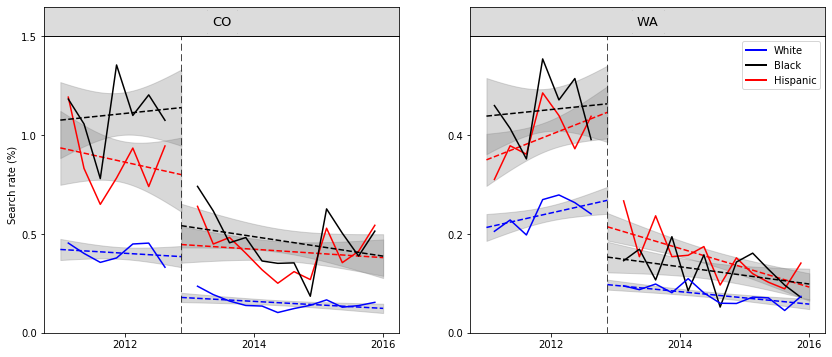

In [9]:
#PLOTTING
##Creation of the figure
fig, ax = plt.subplots(1,2,figsize=(14,6))

##Creation of a boolean indicating the time pre or post legalization
pre  = True
post = False

##Computing the regression and the originak curves and the CI and plotting them on the figure definined before - thanks to the function defined above
###For Colorado, successively pre and post legalization, for hispanic, black and white drivers.
interpolate(CO_hisp_sorted, pre, ax[0], 'red')
interpolate(CO_black_sorted, pre, ax[0], 'black')
interpolate(CO_white_sorted, pre, ax[0], 'blue')
interpolate(CO_hisp_sorted, post, ax[0], 'red')
interpolate(CO_black_sorted, post, ax[0], 'black')
interpolate(CO_white_sorted, post, ax[0], 'blue')

###For Washington, idem
interpolate(WA_hisp_sorted, pre, ax[1], 'red')
interpolate(WA_black_sorted, pre, ax[1], 'black')
interpolate(WA_white_sorted, pre, ax[1], 'blue')
interpolate(WA_hisp_sorted, post, ax[1], 'red')
interpolate(WA_black_sorted, post, ax[1], 'black')
interpolate(WA_white_sorted, post, ax[1], 'blue')

###labels
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2)]

ax[1].legend(custom_lines, ['White', 'Black', 'Hispanic'])

###graph settings: axis, labels, title, scale
ax[0].set(xlabel=None, ylabel='Search rate (%)', title='CO')
ax[0].axvline(pd.to_datetime('2012-11-15'), ls = (1, (10,5)), color = 'black', lw = 0.7 )
ax[0].set_ylim(0,1.5)
ax[0].set_yticks([0, 0.5,1,1.5])
ax[0].set_xticks(pd.to_datetime(['2012','2014','2016']))
ax[0].set_xticklabels(['2012','2014','2016'])

ax[1].set(xlabel=None, ylabel = None, title='WA')
ax[1].axvline(pd.to_datetime('2012-11-15'), ls = (1, (10,5)), color = 'black', lw = 0.7 )
ax[1].set_ylim(0,0.6)
ax[1].set_yticks([0, 0.2,0.4])
ax[1].set_xticks(pd.to_datetime(['2012','2014','2016']))
ax[1].set_xticklabels(['2012','2014','2016'])

###Display of the title in the grey box
divider1 = make_axes_locatable(ax[0])
ax[0] = divider1.append_axes("top", size="10%", pad=0)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_facecolor('gainsboro')
at1 = AnchoredText("CO", loc=10, prop=dict(backgroundcolor='gainsboro', size=13, color='black'))
ax[0].add_artist(at1)

divider2 = make_axes_locatable(ax[1])
ax[1] = divider2.append_axes("top", size="10%", pad=0)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_facecolor('gainsboro')
at2 = AnchoredText("WA", loc=10, prop=dict(backgroundcolor='gainsboro', size=13, color='black'))
ax[1].add_artist(at2)



Comments:
Here is a reproduction of figure 4 of the article. 
We obtain a graph with a satisfactory resemblance, except for the linear regression for pre-legalized black drivers in both states of interest. Having noticed this difference, I tried two different regression techniques (using scipy functions or using the numpy poyfit and polyval functions. Each time I obtained the same line, without being able to obtain the one of the article. If I had to push my research further without time constraints, I would direct my research on the data sorting side or I would try other interpolation methods hoping to find the one of the article. The most troubling thing is that my lines for the other origins or other time period broadly correspond to those of the article.
Moreover, my confidence interval does not perfectly match that of the article. The researchers seem to have used methods to process the computed CI, such as the bootstrap method, which I did not use. This may explain the slight differences.

In [23]:
#DATASET USED:
df = pd.read_csv('data/opp-stops_state.csv')
df = df.dropna()
df.head()

,state,city,geography,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n
418,CT,Statewide,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.76,160113.12
419,CT,Statewide,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.32,25650.72
420,CT,Statewide,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.12,21654.72
421,CT,Statewide,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.80,160113.12
422,CT,Statewide,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.16,25650.72


In [75]:
df['stops_per_year'] = (df['stops_per_year'] / (df['stops_per_year']).max()).astype(float)

black = df[df['subject_race'].str.contains('black')]
white = df[df['subject_race'].str.contains('white')]
hisp  = df[df['subject_race'].str.contains('hispanic')]

hit_black = black[['subgeography', 'hit_rate', 'stops_per_year']]
white = white.set_index(hit_black.index)
hit_black['hit_white'] = white['hit_rate']

thres_black = black[['subgeography', 'inferred_threshold', 'stops_per_year']]
thres_black['thres_white'] = white['inferred_threshold']

hit_hisp = hisp[['subgeography', 'hit_rate', 'stops_per_year']]
white = white.set_index(hit_hisp.index)
hit_hisp['hit_white'] = white['hit_rate']

thres_hisp = hisp[['subgeography', 'inferred_threshold', 'stops_per_year']]
thres_hisp['thres_white'] = white['inferred_threshold']

In [76]:
hit_black.head()

,subgeography,hit_rate,stops_per_year,hit_white
419,Fairfield County,0.315113,0.057370,0.356108
422,Hartford County,0.303398,0.061072,0.319820
425,Litchfield County,0.301587,0.010237,0.413978
431,New Haven County,0.247191,0.067138,0.357401
434,New London County,0.331683,0.034599,0.335580


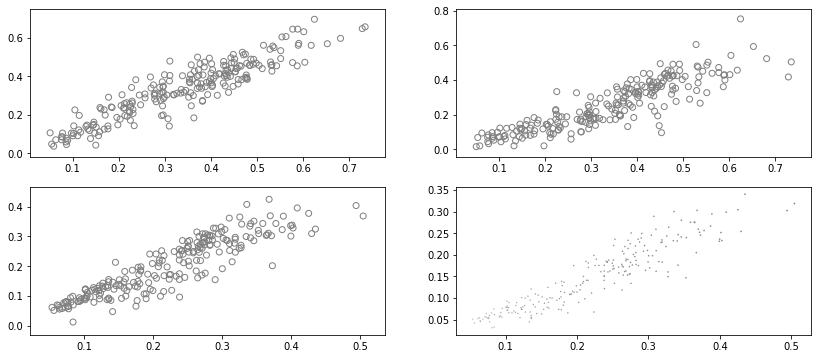

In [81]:
fig, ax = plt.subplots(2,2,figsize=(14,6))

ax[0,0].scatter(hit_black.hit_white, hit_black.hit_rate, facecolors='none', edgecolors='grey')
ax[0,1].scatter(hit_black.hit_white, hit_hisp.hit_rate, facecolors='none', edgecolors='grey')
ax[1,0].scatter(thres_black.thres_white, thres_black.inferred_threshold, facecolors='none', edgecolors='grey')
ax[1,1].scatter(thres_black.thres_white, thres_hisp.inferred_threshold, thres_hisp.thres_white, facecolors='none', edgecolors='grey')

plt.show()